In [83]:
%matplotlib inline
import curveball
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

In [76]:
def logistic_ode(y, t, r, K, nu, q0, v):
    return r * y * (1 - y/K)


def richards_ode(y, t, r, K, nu, q0, v):
    return r * y * (1 - (y/K)**nu)


def baranyi_roberts_ode(y, t, r, K, nu, q0, v):
    alfa = q0 / (q0 + np.exp(-v * t))
    return alfa * r * y * (1 - (y/K)**nu)


def compare_curves(y1, y2):
    return (abs(y1 - y2) / y1).mean()

In [77]:
t = np.linspace(0, 12, 100)
y0 = 0.1
r = 0.75
K = 1.
nu = 5.
q0 = 0.1
v = 1.0
noise = 0.05
reps = 30
rng = np.random.RandomState(1221)

In [78]:
def make_df(func_ode):
    y = odeint(func_ode, y0, t, args=(r, K, nu, q0, v))
    y.resize((len(t),))
    y += rng.normal(0, noise, len(t))
    y[y<=0] = 0
    df = pd.DataFrame({'OD':y, 'Time': t})
    return df

In [79]:
def fit(df, expected_model, expected_nvarys):
    models,fig,ax = curveball.models.fit_model(df, PLOT=True, PRINT=False)
    return models

y0 0.1 r 0.75 K 1.0 nu 5.0


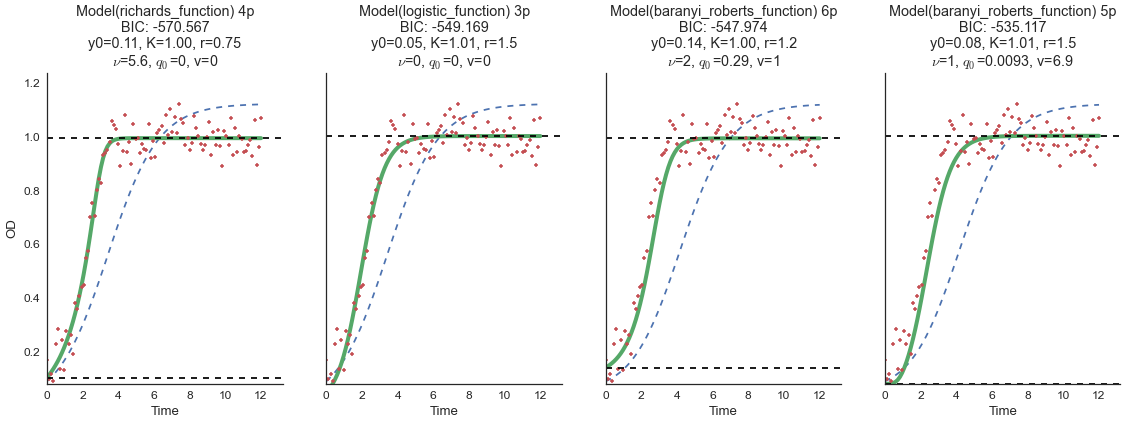

In [80]:
print "y0",y0,"r",r,"K",K,"nu",nu
df = make_df(richards_ode)
models = fit(df, curveball.models.richards_model, 4)
model_fit = models[0]

In [81]:
# names = [p.name for p in model_fit.params.values() if p.vary]
# means = [p.value for p in model_fit.params.values() if p.vary]
# #stds  = [p.stderr for p in model_fit.params.values() if p.vary]
# #cov = np.diag(stds)
# cov = model_fit.covar

In [84]:
nsamples = 1000

#param_samples = rng.multivariate_normal(means, cov, nsamples)
#param_samples = pd.DataFrame(param_samples, columns=names)
reload(curveball.models)
param_samples = curveball.models.sample_params(model_fit, nsamples)
param_samples.head()

,y0,r,K,nu
0,0.113568,0.708929,0.998214,7.143605
1,0.107246,0.709046,1.000674,6.528099
2,0.102981,0.736649,0.995716,7.785594
3,0.099408,0.756060,0.995441,6.333983
4,0.099796,0.808492,0.992113,4.976471


In [108]:
reload(curveball.plots)

<module 'curveball.plots' from 'd:\workspace\curveball_project\python\curveball\plots.py'>

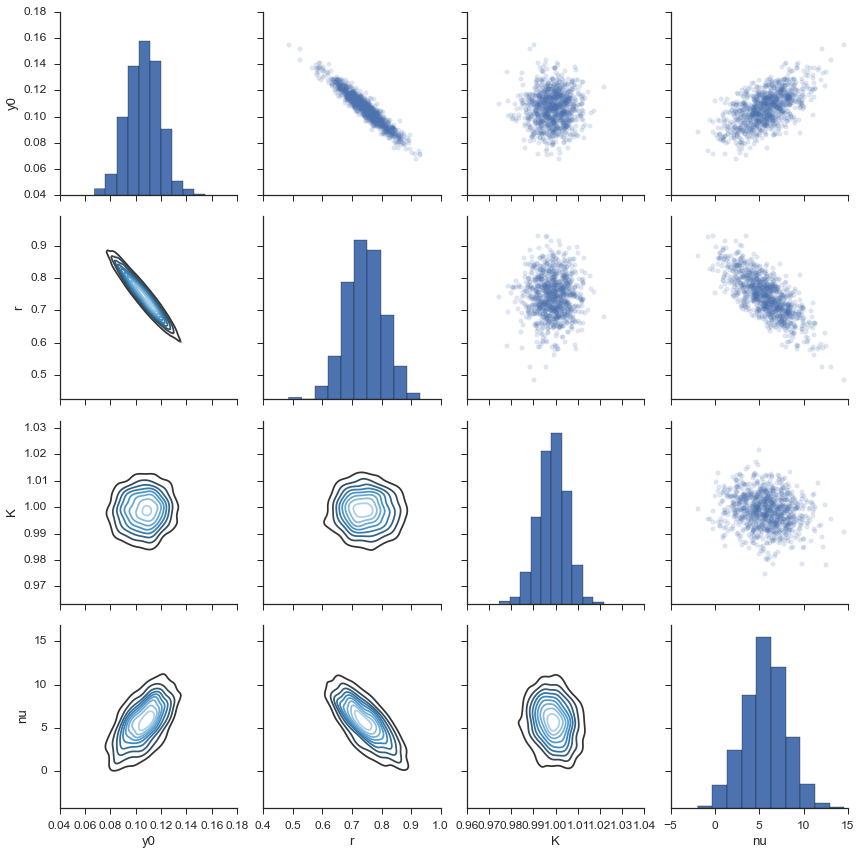

In [109]:
curveball.plots.plot_params_distribution(param_samples)

In [39]:
t = model_fit.userkws['t']
y = np.zeros((len(t),nsamples))
for i in range(nsamples):
    y0,r,K,nu = param_samples.loc[i]
    y[:,i] = model_fit.model.func(t=t, y0=y0, r=r, K=K, nu=nu)

In [74]:
from lmfit import Parameters
_params_ = param_samples.loc[i].to_dict()
print _params_
model_fit.model.func(t=t, K=_params_['K'], y0=_params_['y0'], r=_params_['r'], nu=_params_['nu'])

{'y0': 0.12257171568562947, 'K': 0.98682236311266658, 'r': 0.67247552212880746, 'nu': 9.2103984724174168}


array([ 0.123,  0.144,  0.17 ,  0.2  ,  0.235,  0.277,  0.326,  0.384,  0.452,
        0.531,  0.625,  0.731,  0.842,  0.93 ,  0.971,  0.983,  0.986,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,  0.987,
        0.987])

In [40]:
meany = np.nanmean(y, axis=1)
stdy = np.nanstd(y, axis=1, ddof=1) 
ci_low, ci_high = scipy.stats.norm.interval(0.99, loc=meany, scale=stdy)
assert np.isfinite(ci_low).all()
assert np.isfinite(ci_high).all()

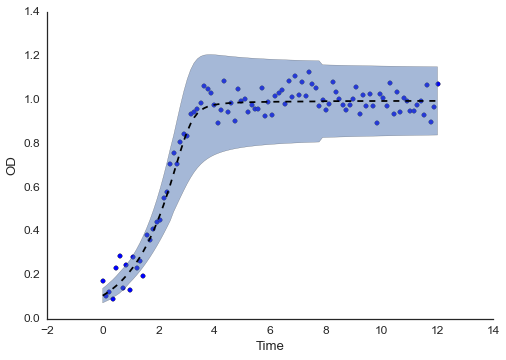

In [41]:
plt.scatter(t, model_fit.data, marker='o')
plt.plot(t, meany, '--k')
plt.fill_between(t, ci_low, ci_high, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine()

y0 0.122571715686 r 0.8 K 0.986822363113 nu 9.21039847242


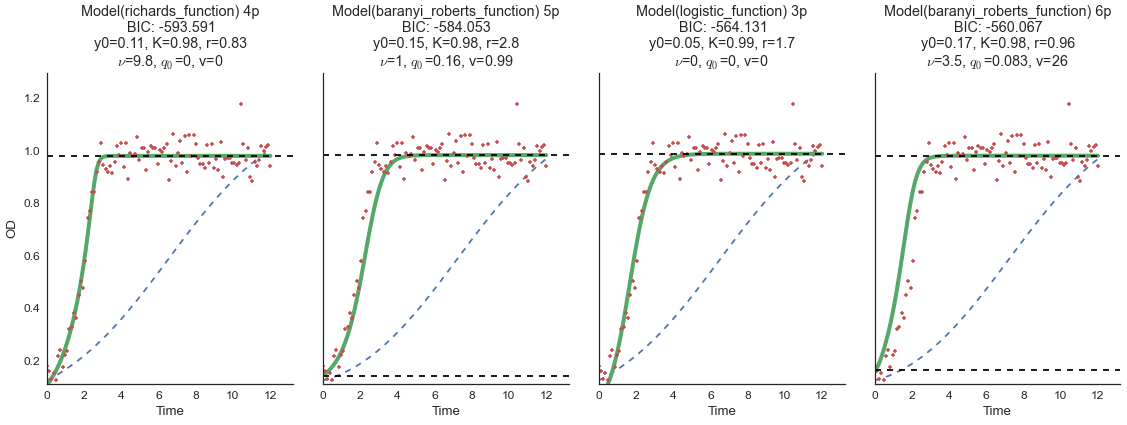

In [42]:
r = 0.8
print "y0",y0,"r",r,"K",K,"nu",nu
df2 = make_df(richards_ode)
models2 = fit(df2, curveball.models.richards_model, 4)
model_fit2 = models2[0]

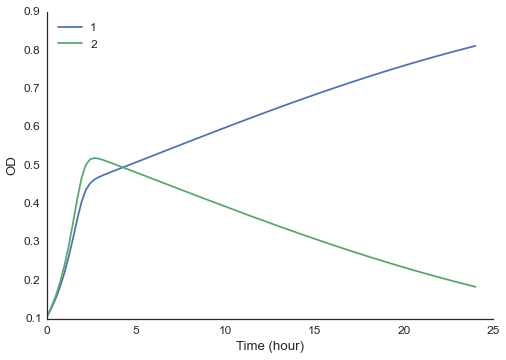

In [43]:
t,y,fig,ax = curveball.competitions.compete(model_fit, model_fit2, PLOT=True)
ax.legend([1,2], loc='upper left')

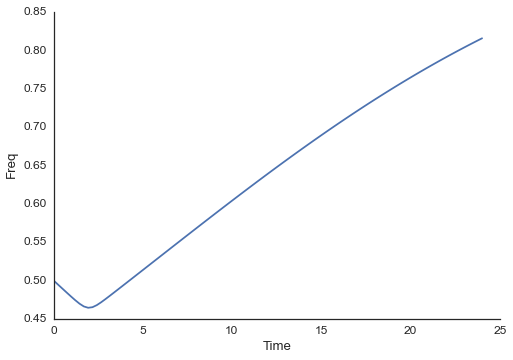

In [44]:
p = y[:,0] / y.sum(axis=1)
plt.plot(t,p)
plt.xlabel('Time')
plt.ylabel('Freq')
sns.despine()

In [45]:
means2 = [p.value for p in model_fit2.params.values() if p.vary]
cov2 = model_fit2.covar
param_samples2 = rng.multivariate_normal(means2, cov2, nsamples)